$$\textbf{Chad Schupbach}$$

***

In [1]:
import os

In [2]:
path = '/Users/chadschupbach/opt/anaconda3/'
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = path + 'share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = path + 'lib/libplaidml.dylib'

In [3]:
import torch
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from src import utils

Using plaidml.keras.backend backend.


Convolutional neural networks (CNN) classify high-dimensional input data by extracting feature maps in an iterative process known as feature learning.

$$\textsf{input} \ \ \longrightarrow \ \ \textsf{feature learning} \ \ \longrightarrow \ \ \textsf{classification}$$

In this notebook, we introduce various components of convolutional neural networks and how they can be used to assemble an effective CNN classifier. For more information about training CNN models, please see the [cnn_model](https://github.com/cschupbach/deep_learning_cnn/blob/master/cnn_model.ipynb) notebook where we train an ensemble CNN to predict handwritten digits with a testing accuracy of 99.61%.

# Feature Learning

The feature learning segment of the network is a set of feature maps or layers primarily constructed using convolutional kernels convolved with the input layers in a sequence.

$$\textsf{input} \ \ \circledast \ \ \text{conv}_{1} \ \ \circledast \ \cdots \ \circledast \ \text{conv}_{N} \ \ \longrightarrow \ \textsf{classification}$$

## Convolutional Layers
### Input/Output

Here we discuss the role of convolutional kernels/filters in CNN architecture. Given a convolutional kernel function $\Omega$, the kernel of $\omega$ is convolved with an input layer $x_\text{in}$, such that,

$$x_\text{out} = \Omega(x_\text{in})\tag{1}$$

where $x_\text{out}$ is the output layer. The shape of the output layer $x_\text{out}$ is dependent on the shape of the input layer $x_\text{in} \in \mathbb{R}^{H_\text{in} \times W_\text{in} \times D_\text{in}}$ and the hyperparameters of the kernel function $\Omega$: the number of kernels $K$, kernel size $F$, the stride $S$, and the amount of padding $P$ used on the input border.

$$x_\text{in} \in \mathbb{R}^{H_\text{in} \times W_\text{in} \times D_\text{in}} \quad\overset{\Omega}{\longrightarrow}\quad x_\text{out} \in \mathbb{R}^{H_\text{out} \times W_\text{out} \times D_\text{out}}$$

where

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1\tag{2}$$

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1\tag{3}$$

$$D_\text{out} = K\tag{4}$$


#### Example 1

Let the input layer $x_\text{in}$ be a tensor of size ${5 \times 5 \times 1}$ and the hyperparameters of $\Omega$ be $K=2$, $F=3$, $S=1$ and $P=0$, such that,

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$D_\text{out} = K = 2$$

Therefore, the output $x_\text{out} \in \mathbb{R}^{3 \times 3 \times 2}$ is a feature map with 2 layers and each layer is a $3 \times 3$ matrix. Further information about specific kernel functions and convolution can be found in the [`image_processing`](https://github.com/cschupbach/image_processing) repository.

### PyTorch
Example 2 briefly introduces the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module as an introduction to the PyTorch library. While the remainder of the notebook uses the Keras library, both PyTorch and Keras offer similar tools for constructing convolutional neural networks.

Note that PyTorch documentation specifies use of an input tensor in *channels first* format. This means the default input tensor for 2-dimensional convolution is expected to have the shape $N \times C_\text{in} \times H_\text{in} \times W_\text{in}$, where $N$ is the batch size, $C_\text{in}$ is the number of input channels/layers, $H_\text{in}$ is the input height or the number of rows, and $W_\text{in}$ is the width or the number of columns. Alternatively, Keras 2-dimensional convolution expects an input tensor of shape $N \times H_\text{in} \times W_\text{in} \times C_\text{in}$, which is known as *channels last* format.

#### Example 2

Using [`utils.py`](https://github.com/cschupbach/deep_learning_cnn/blob/master/src/utils.py), we load image 9 of the Keras MNIST [dataset](https://keras.io/datasets/) below.

In [4]:
x = utils.load_mnist(sample=9)

torch.Size([1, 1, 28, 28])


Below, we use the `torch.nn` function `Conv2d` to create two 2-dimensional convolution objects, `conv1` and `conv2`. The first convolution object `conv1` uses 3 kernel filters ($K=3$) and no zero padding ($P=0$) of the input border, while `conv2` uses 6 kernel filters ($K=6$) and adds one pixel of zero padding ($P=1$) to the input border. Both convolution objects have kernel size $F=3$, stride $S=1$, and one input channel, given that the input tensor is of size $1 \times 1 \times 28 \times 28$.

In [5]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                        stride=1, padding=0)

In [6]:
conv2 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,
                        stride=1, padding=1)

The kernels of each convolution object convolve the input `x` as follows:

In [7]:
x1 = conv1(x).detach().numpy()
x2 = conv2(x).detach().numpy()

We apply the `network` function to object `Plot` of the `utils` module to plot the results of each convolution below.

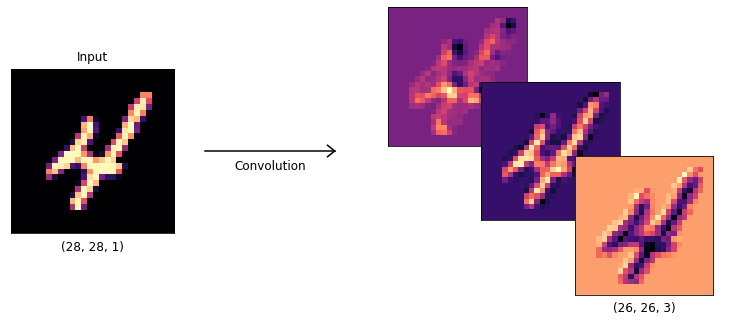

In [8]:
utils.Plot().network(x, [x1])

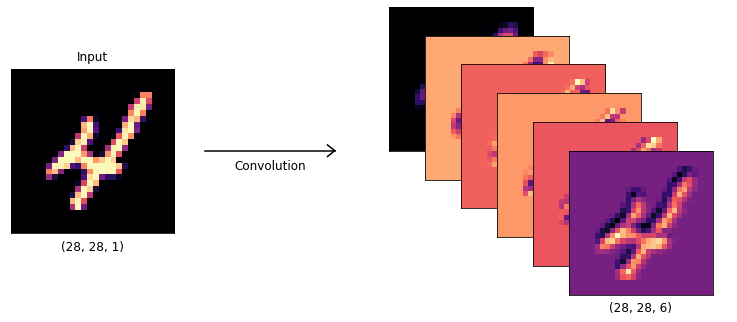

In [9]:
utils.Plot().network(x, [x2])

## Activation Functions

Most CNN architectures also apply an activation function to convolutional layers. We use activation functions to increase non-linearity in the network. In theory, the output layers of convolution with activation have a thresholding effect similar to that of action potentials in the biological firing of neurons.

$$\textsf{input} \ \ \circledast \ \ \text{conv}_{1} \ + \ \text{activation}_1 \ \circledast \ \cdots \ \circledast \ \text{conv}_{N} \ + \ \text{activation}_N \longrightarrow \ \textsf{classification}$$

### Rectified Linear Unit  (ReLU)
$$f(x) = \begin{cases} 0 & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

Here we provide an example of convolution with ReLU activation using Keras. Because the Keras library uses *channels last* format (by default) for 2-dimensional convolution, we reload the same MNIST image in the proper format as follows:

In [10]:
x = utils.load_mnist(method='keras', sample=9)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


Shape(dtype=<DType.FLOAT32: 50>, dims=(1, 28, 28, 1))


We create two 2-dimensional convolution objects with ReLU activation, `relu1` and `relu2`, using the Keras function `Conv2D` below. The first convolution object `relu1` uses 3 kernel filters ($K=3$) and no zero padding ($P=0$) of the input border, while `relu2` uses 6 kernel filters ($K=6$) and adds one pixel of zero padding ($P=1$) to the input border. Both convolution objects have kernel size $F=3$ and stride $S=1$ (default). Note that the zero padding parameter is either `'valid'` (default), where $H_\text{out}$ and $W_\text{out}$ are according to equations (2) and (3) with $P=0$, or `'same'`, where $H_\text{out} = H_\text{in}$ and $W_\text{out}=W_\text{in}$.

In [11]:
relu1 = Conv2D(filters=3, kernel_size=3, strides=1, padding='valid',
               activation='relu')
relu2 = Conv2D(filters=6, kernel_size=3, strides=1, padding='same',
               activation='relu')

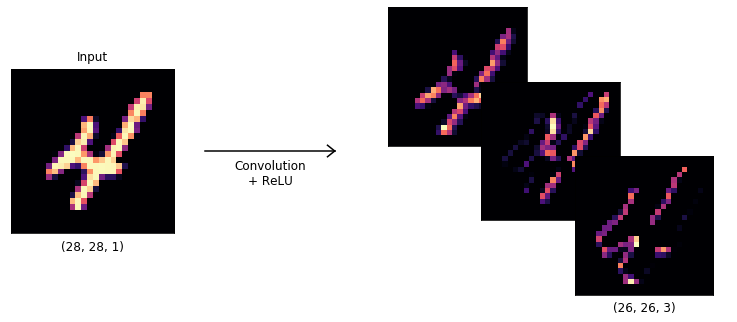

In [12]:
utils.display_conv(x, relu1, activation='ReLU')

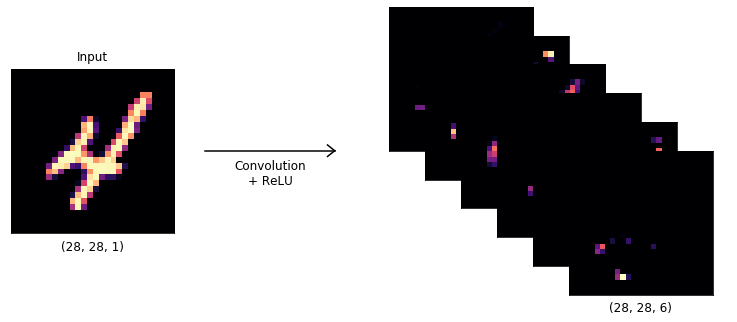

In [13]:
utils.display_conv(x, relu2, activation='ReLU')

### Softmax
$$P(y=j| \mathbf{x}) = \frac{e^{\mathbf{x}^\mathsf{T}\mathbf{w}_j}}{\sum_{k=1}^{k} e^{\mathbf{x}^\mathsf{T}\mathbf{w}_k}}$$

In [14]:
softmax = Conv2D(filters=3, kernel_size=3, activation='softmax')

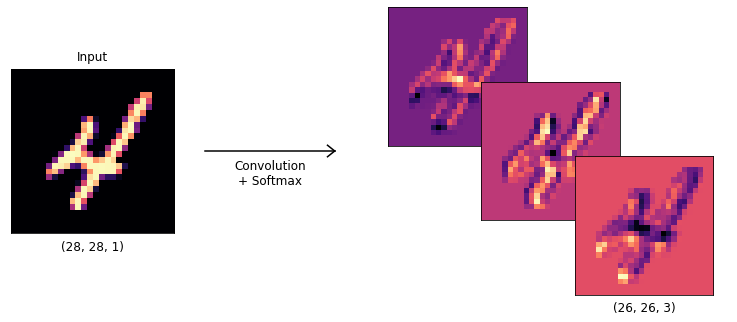

In [15]:
utils.display_conv(x, softmax, activation='Softmax')

### Sigmoid
$$f(x) = \sigma(x) = \frac{1}{1 + e^{-x}}$$

In [16]:
sigmoid = Conv2D(filters=3, kernel_size=3, activation='sigmoid')

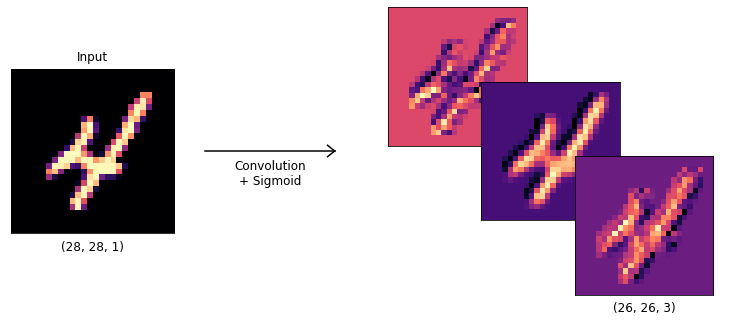

In [17]:
utils.display_conv(x, sigmoid, activation='Sigmoid')

### Hyperbolic Tangent (tanh)
$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [18]:
tanh = Conv2D(filters=3, kernel_size=3, activation='tanh')

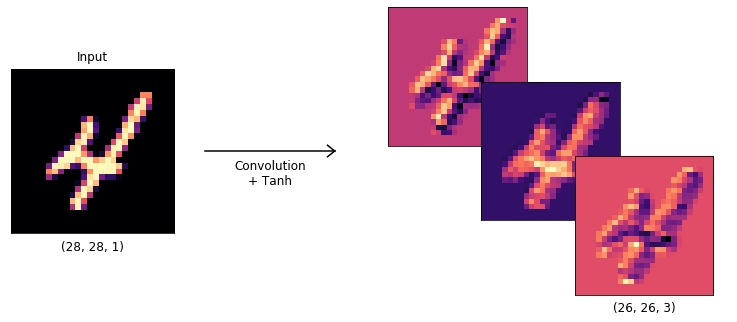

In [19]:
utils.display_conv(x, tanh, activation='Tanh')

### Exponential Linear Unit (ELU)
$$f(\alpha, x) = \begin{cases} \alpha (e^x - 1) & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

In [20]:
elu = Conv2D(filters=3, kernel_size=3, activation='elu')

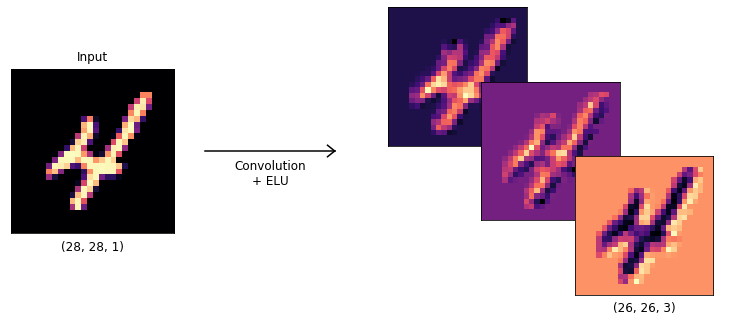

In [21]:
utils.display_conv(x, elu, activation='ELU')

### Softplus
$$f(x) = \ln(1 + e^x)$$

In [22]:
softplus = Conv2D(filters=3, kernel_size=3, activation='softplus')

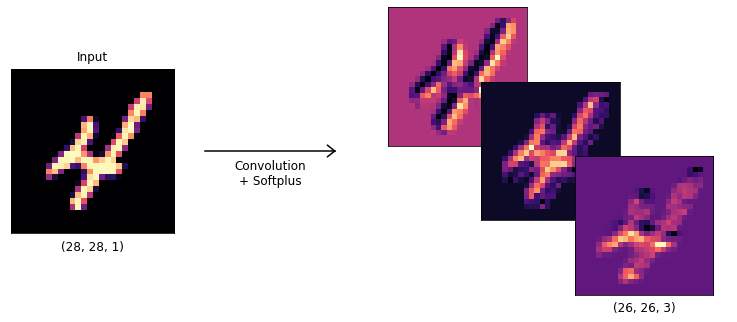

In [23]:
utils.display_conv(x, softplus, activation='Softplus')

### Softsign
$$f(x) = \frac{x}{1 + |x|}$$

In [24]:
softsign = Conv2D(filters=3, kernel_size=3, activation='softsign')

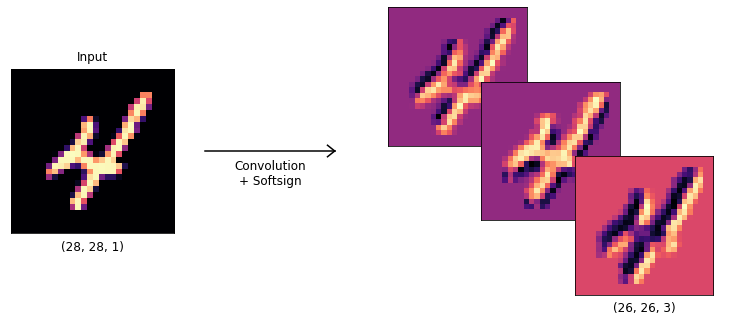

In [25]:
utils.display_conv(x, softsign, activation='Softsign')

### Others

- Leaky ReLU

- PReLU

- RReLU

- SELU

- GELU

## Pooling

Pooling methods are often used between certain convolutions for dimensionality reduction. The most common method for pooling input layers is *max* pooling using a $2 \times 2$ kernel with non-overlapping strides. In certain cases with very large input, pooling with a $3 \times 3$ kernel may be effective. Typically, *max* pooling produces better results than the less common *average* pooling.

### Max Pooling

In [26]:
relu = Conv2D(filters=6, kernel_size=3, padding='same', activation='relu')
tanh = Conv2D(filters=6, kernel_size=3, padding='same', activation='tanh')

In [27]:
maxpool = MaxPooling2D(pool_size=(2, 2))

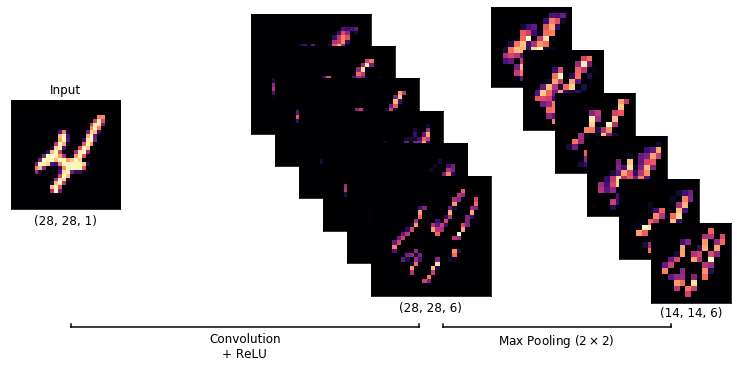

In [28]:
utils.display_conv_pool(x, [relu, maxpool], network_id=0)

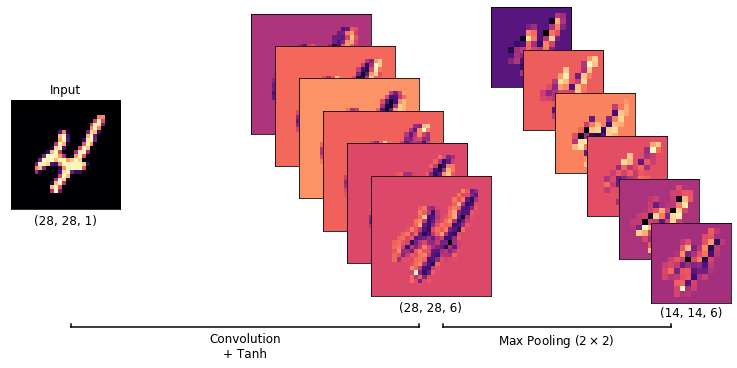

In [29]:
utils.display_conv_pool(x, [tanh, maxpool], network_id=1)

### Average Pooling

In [30]:
avgpool = AveragePooling2D(pool_size=(2, 2))

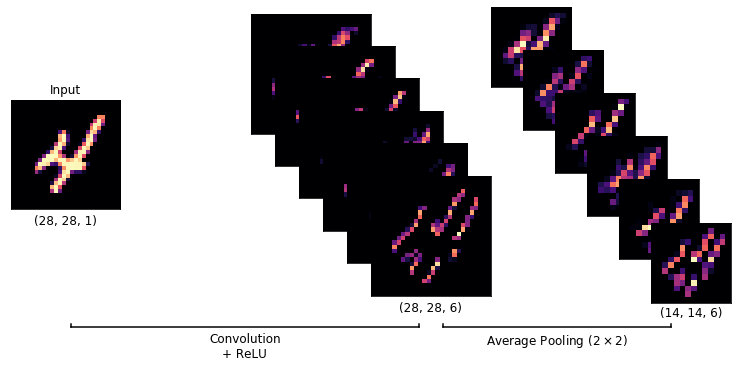

In [31]:
utils.display_conv_pool(x, [relu, avgpool], network_id=2)

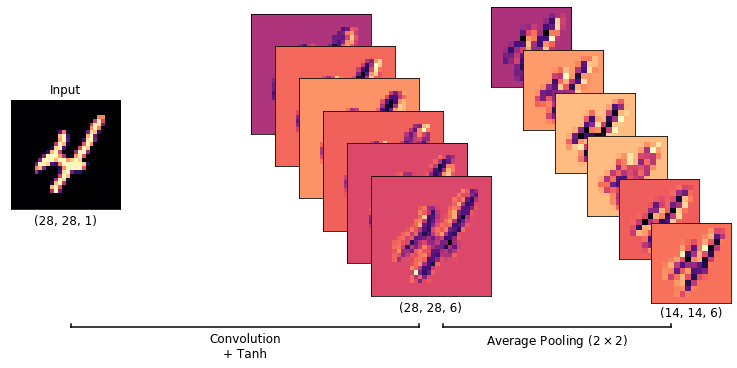

In [32]:
utils.display_conv_pool(x, [tanh, avgpool], network_id=3)

## Stacking Layers

In [33]:
relu = Conv2D(filters=6, kernel_size=3, padding='same', activation='relu')
tanh = Conv2D(filters=6, kernel_size=3, padding='same', activation='tanh')

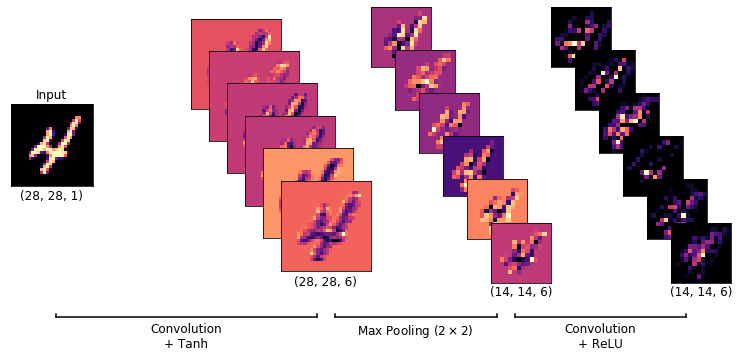

In [34]:
utils.display_conv_pool(x, [tanh, maxpool, relu], network_id=4)

In [35]:
maxpool = MaxPooling2D(pool_size=(2, 2))
relu1 = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')
relu2 = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
relu3 = Conv2D(filters=16, kernel_size=3, activation='relu')

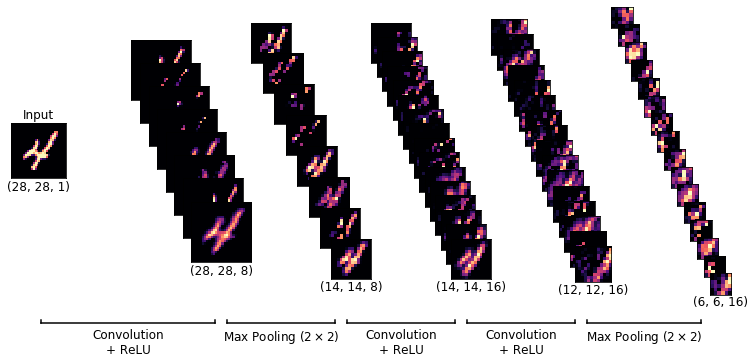

In [36]:
utils.display_conv_pool(x, [relu1, maxpool, relu2, relu3, maxpool],
                        network_id=5)

A common CNN feature learning architecture is similar to that shown above, where feature maps are constructed with ReLU-activated convolutional layers and intermittent max pooling. It's also fairly common to normalize the batch of input layers prior to convolution in the feature learning segment.

# Classification

In the classification segment of the network, we flatten the final feature learning layer to form fully connected (FC) layers.

## Fully Connected (FC) Layers

Here, we introduce FC layers by building a network of feature learning layers using Keras [`Sequential`](https://keras.io/api/models/sequential/) class. We initialize a sequential object and add feature learning layers to the model as follows:

In [37]:
model = Sequential()
model.add(Conv2D(8, 3, padding='same', activation='relu',
                 input_shape=(28, 28, 1), name='conv_1'))
model.add(Conv2D(8, 3, padding='same', activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool_1'))
model.add(Conv2D(16, 3, activation='relu', name='conv_3'))
model.add(Conv2D(16, 3, activation='relu', name='conv_4'))
model.add(Conv2D(16, 3, activation='relu', name='conv_5'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool_2'))

![Example of fully connected layers where the flattened input layer is fed into a sequence of dense, fully connected layers. Neurons of each fully connected layer are linked to all activations in the prior layer.](fig/figure01.png)

**Figure 1.** Example of fully connected layers where the flattened input layer is fed into a sequence of dense, fully connected layers. Neurons of each fully connected layer are linked to all activations in the prior layer.

### Flatten
The output layers of the feature learning network above has the shape $4 \times 4 \times 16$. To begin the classification segment of the CNN, we flatten the output layers forming input array of length 256 similar to that of the simplified neural network shown in Figure 1 [[1](https://www.researchgate.net/publication/331525817_Temporal_Convolutional_Neural_Network_for_the_Classification_of_Satellite_Image_Time_Series)].

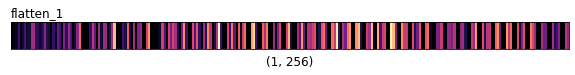

In [38]:
model.add(Flatten(name='flatten_1'))
utils.display_fc(model, x)

### Dense
We sequentially add to the model two ReLU-activated fully connected layers of size 128 and a Softmax-activated output layer with a length equal to the number of classes (in our case 10).

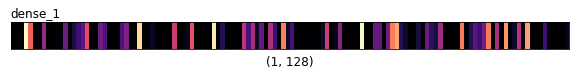

In [39]:
model.add(Dense(128, activation='relu', name='dense_1'))
utils.display_fc(model, x)

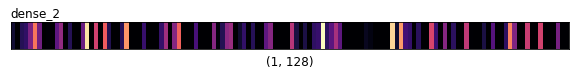

In [40]:
model.add(Dense(128, activation='relu', name='dense_2'))
utils.display_fc(model, x)

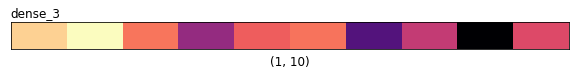

In [41]:
model.add(Dense(10, activation='softmax', name='dense_3'))
utils.display_fc(model, x)

### Network Summary

The network can be summarized as follows:

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         584       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 14, 14, 8)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 16)        1168      
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 16)        2320      
_________________________________________________________________
conv_5 (Conv2D)              (None, 8, 8, 16)          2320      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 16)          0         
__________

# Additional Layers and Functions

Many additional layers and layer functions may be added to fine tune the base architecture of the CNN shown above based on the data being classified. While a few common additions are discussed below, we highly suggest reviewing documentation for the [Keras Layers API](https://keras.io/api/layers/).

## Batch Normalization
We use batch normalization to scale values of inputs to mean zero and unit variance. This helps account for a problem called covariate shift, where the distribution of data varies across training and testing batch inputs. For some datasets, batch normalization may increase efficiency by reducing the number of epochs required to effectively train the CNN. However, batch normalization may not be suitable in some instances due to an increase in the amount of time required to complete an epoch. Results typically depend on the data and where batch normalizations are added in the model. For a dataset like MNIST, where the distribution of pixel values of is likely similar across large batches of input data, batch normalization may not be worth the increase in computational complexity.

## Dropout Layers
A dropout layer is a regularization method where a proportion of input values are randomly set to zero. Doing this reduces the amount of overfitting while training and results in a fit more robust to potential outliers. We typically apply dropout layers to inputs of the fully connected layers during the classification segment of the network. 

## L1/L2 Regularization
Regularization techniques like L1 and L2 regularization can be applied to layers of the network to reduce/prevent overfitting. The regularizers are added as penalty terms to the weight parameters of the loss function to reduce model complexity.

# Citations

1. C. Pelletier, G. Webb, and F. Petitjean, "Temporal Convolutional Neural Network for the Classification of Satellite Image Time Series," *Remote Sensing*, vol. 11, no. 5, p. 523, 2019.